In [1]:
import pandas as pd

data_row=pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/no gpt/NO gpt train data.csv",index_col=0)

data_row

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,predict
0,0.052607,-0.053146,-0.012321,-0.014028,0.006890,-0.004457,-0.028779,0.008729,0.079076,-0.018651,...,-0.035216,-0.004926,0.002643,-0.041705,-0.073804,0.011732,0.023657,0.023674,-0.021644,0
1,0.065640,-0.056633,-0.012326,-0.016592,-0.000792,0.000747,-0.054616,0.016118,0.057677,-0.018877,...,-0.044232,-0.005241,0.006694,-0.043336,-0.056174,0.029313,0.019381,0.020676,-0.005578,0
2,0.069203,0.005305,-0.026596,0.008959,0.006379,0.003055,-0.019259,0.008808,0.090986,-0.012824,...,0.003346,0.024238,-0.002917,-0.040966,-0.080141,0.006348,0.023794,0.016556,-0.028141,2
3,0.048832,-0.030371,-0.013756,-0.014487,0.036973,0.022373,-0.071002,0.022927,0.065173,-0.012395,...,-0.019971,0.005966,-0.027569,-0.053896,-0.080093,-0.018758,0.014429,0.037310,-0.016282,0
4,0.046536,-0.022251,-0.027004,0.025981,0.022376,-0.013689,-0.050305,0.025515,0.044787,0.012179,...,-0.000852,0.002012,0.017530,-0.016844,-0.010146,-0.008205,0.021647,0.003026,-0.051527,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.103314,-0.055173,-0.020592,0.040117,0.033047,0.013462,-0.041553,0.026483,0.077640,-0.022566,...,-0.004895,-0.002905,0.013308,-0.044995,-0.075419,0.004471,0.014530,0.021715,-0.006937,1
2996,0.067874,-0.063887,-0.029778,-0.007054,0.036702,-0.005829,-0.014136,0.001677,0.047928,-0.010099,...,-0.035204,-0.003959,0.004056,-0.057046,-0.048743,-0.001795,0.026904,0.016072,-0.034152,0
2997,0.050919,-0.081113,-0.025674,-0.021389,-0.005436,-0.005959,0.013455,-0.004437,0.058308,-0.006634,...,-0.033325,-0.022092,0.022104,-0.035005,-0.049889,0.017549,0.018456,0.006250,-0.027227,0
2998,0.033868,-0.028757,-0.018064,-0.003613,0.036243,-0.017056,-0.072555,0.026048,0.054409,-0.012396,...,-0.021542,0.036983,-0.019718,-0.032257,-0.068770,0.019108,0.026003,0.019968,-0.025191,0


In [2]:

import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
device = torch.device("mps")  # MPS 장치 사용

tensor([1.], device='mps:0')


In [3]:
import math
import torch
from torch.optim.optimizer import Optimizer

class PADAM(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, partial=1/4):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, partial=partial)
        super(PADAM, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('PADAM does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr'] * math.pow(state['step'], -group['partial'])

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
# 데이터 불러오기 및 전처리
data_row = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/no gpt/NO gpt train data.csv", index_col=0)
y_train = pd.get_dummies(data_row['predict']).values
X_train = data_row.drop(columns=['predict']).values

test = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/no gpt/NO gpt test data.csv", index_col=0)
test_y = pd.get_dummies(test['predict']).values
test_x = test.drop(columns=['predict']).values

In [6]:

X_train = torch.tensor(X_train, dtype=torch.float).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
test_x = torch.tensor(test_x, dtype=torch.float).unsqueeze(1).to(device)
test_y = torch.tensor(test_y, dtype=torch.float).to(device)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([3000, 1, 768])
torch.Size([3000, 3])
torch.Size([300, 1, 768])
torch.Size([300, 3])


In [8]:

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=X_train.shape[2], out_channels=128, kernel_size=2, padding=1)  # 채널 수와 커널 사이즈 조정
        self.bn1 = nn.BatchNorm1d(128)  # 배치 정규화 추가
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)  # 드롭아웃 비율 조정
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)  # LSTM 구조 보강
        self.fc1 = nn.Linear(128*2, 32)  # Fully connected 레이어의 크기 조정
        self.fc2 = nn.Linear(32, 3)
        self.activation = nn.ReLU()  # 활성화 함수 변경

    def forward(self, x):
        x = self.bn1(self.activation(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(self.activation(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(self.activation(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = TextClassifier().to(device)
model.to(device)

TextClassifier(
  (conv1): Conv1d(768, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)

In [10]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = PADAM(model.parameters(), lr=0.002,weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3, verbose=True)

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

def save_checkpoint(state, filename="my_checkpoint.pt"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [12]:
num_epochs = 500
training_losses = []
validation_losses = []


patience = 20  
counter = 0  
best_loss = None  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 MPS 장치로 이동
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
   
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            inputs = inputs.permute(0, 2, 1)  
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_loader)
    validation_losses.append(avg_validation_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}')
    
    scheduler.step(avg_validation_loss)
    
    if best_loss is None:
        best_loss = avg_validation_loss
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})
    elif avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print('Test Fine End')



Epoch 1, Training Loss: 0.5642702594399452, Validation Loss: 0.38493403401381027
=> Saving checkpoint
Epoch 2, Training Loss: 0.41143120552102724, Validation Loss: 0.37376205905495835
=> Saving checkpoint
Epoch 3, Training Loss: 0.3763486512005329, Validation Loss: 0.3419222017979094
=> Saving checkpoint
Epoch 4, Training Loss: 0.35736727317174277, Validation Loss: 0.3341101695780526
=> Saving checkpoint
Epoch 5, Training Loss: 0.3431157723069191, Validation Loss: 0.34516009310241014
Epoch 6, Training Loss: 0.3325671801964442, Validation Loss: 0.3197477361130101
=> Saving checkpoint
Epoch 7, Training Loss: 0.3182613951464494, Validation Loss: 0.31283672463401063
=> Saving checkpoint
Epoch 8, Training Loss: 0.2964060092965762, Validation Loss: 0.27702519936787817
=> Saving checkpoint
Epoch 9, Training Loss: 0.2727496954301993, Validation Loss: 0.3624826084902937
Epoch 10, Training Loss: 0.27162204881509144, Validation Loss: 0.25527776784680706
=> Saving checkpoint
Epoch 11, Training Los

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np



torch.save(model.state_dict(), 'pytorch cnn-bilstm model_state_dict0424.pt')

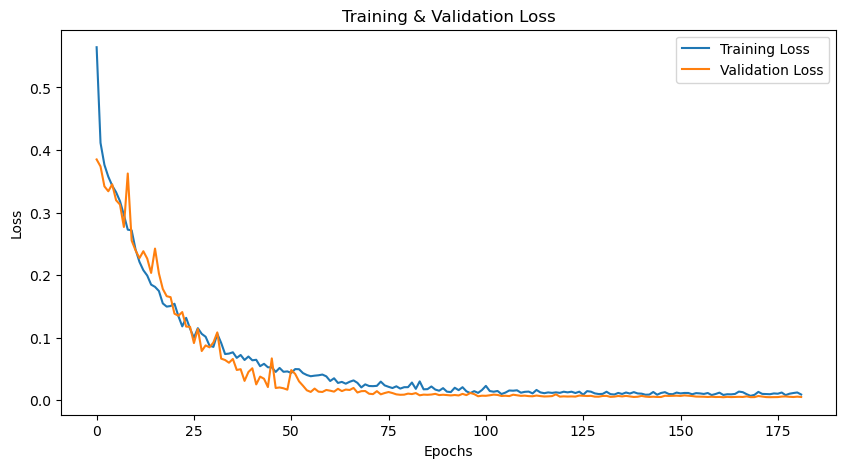

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

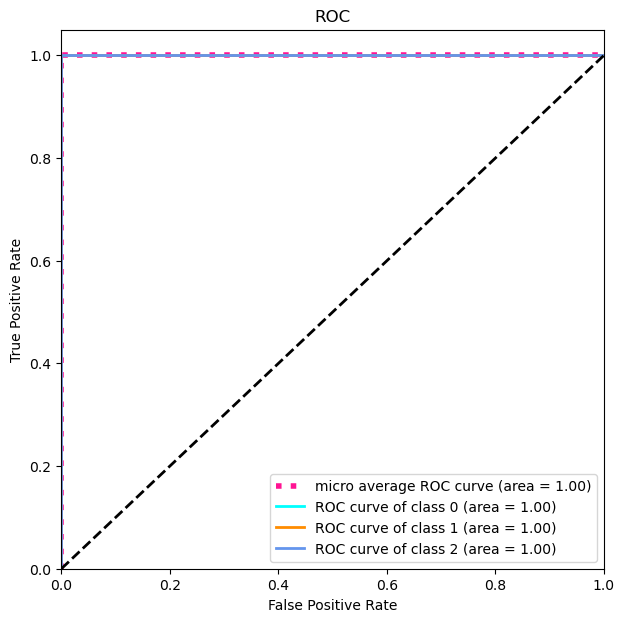

In [15]:

def plot_multiclass_roc_curve(test_y, y_score, n_classes):
   
    test_y_bin = label_binarize(test_y, classes=[*range(n_classes)])

    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

   
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

   
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()





from sklearn.preprocessing import label_binarize

test_x = test_x.permute(0, 2, 1) 
y_score = model(test_x).detach().cpu().numpy()

test_y = test_y.detach().cpu().numpy()

plot_multiclass_roc_curve(test_y, y_score, n_classes=3)

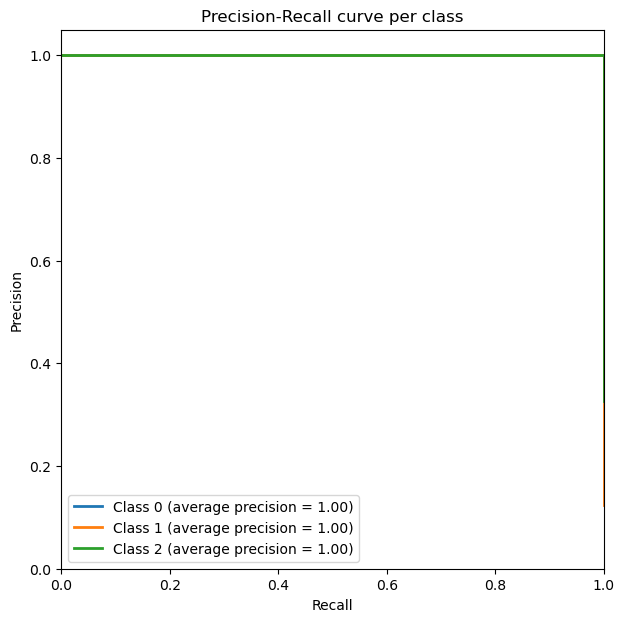

In [16]:
def plot_precision_recall_curve(test_y, y_score, n_classes):
    
    test_y = label_binarize(test_y, classes=[*range(n_classes)])
    
   
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(test_y[:, i], y_score[:, i])

    
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (average precision = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve per class')
    plt.legend(loc="best")
    plt.show()
    
plot_precision_recall_curve(test_y, y_score, n_classes=3)

In [17]:

y_pred = np.argmax(y_score, axis=1)
test_y_labels = np.argmax(test_y, axis=1)  # 실제 레이블

In [18]:

accuracy = accuracy_score(test_y_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


In [19]:
# 혼동 행렬
conf_matrix = confusion_matrix(test_y_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[165   0   0]
 [  0  37   0]
 [  0   0  98]]


In [20]:
with open("CNN BILSTM confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(test_y_labels, y_pred), file=text_file)

In [21]:
# 분류 보고서
class_report = classification_report(test_y_labels, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        98

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [22]:
with open("CNN-BILSTM output.txt", "w") as text_file:
    print(classification_report(test_y_labels, y_pred,digits=4), file=text_file)